# Exercise 3

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](l25_exercise_3.ipynb).*

In [1]:
# Standard library imports
import glob
import os
import re
import random

# NumPy and numba for array processing
import numpy as np
import numba

# SciPy stats for plotting Gaussians
import scipy.stats as st

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Seaborn makes plots pretty!
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# No SVG here; the random walks will result in bloated file size

# Set JB's favorite Seaborn settings
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 
    'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)

## Problem 3.1: Setting up a Python 2 environment
While all major scientific packages are now Python 3 compatible, some are still lagging.  It is therefore useful to have a Python 2 distribution available if you want or need it.  `conda` makes this easy!  Follow the instructions in [Lesson 18](../lessons/l18_more_command_line.html#conda) to set up a Python 2 environment.

### Problem 3.1: solution
This should be self-explanatory from the instructions in [Lesson 18](../lessons/l18_more_command_line.html#conda).

<br />

## Problem 3.2: Making your .bashrc file
Having a `.bashrc` file allows you to configure your shell how you like.

**a)** Create a `.bashrc` file in your home directory.  You can use any text editor you like, even Spyder.  If you already have a `.bashrc` file, open it up for editing.

**b)** Let's first set the `PYTHONPATH` environment variable.  We didn't explicitly do that in the [second command line lesson](../lessons/l18_more_command_line.html).  The instructions on how to do it are there, though.

**c)** It is often useful to `alias` functions to other functions.  For example, I am always worried I will accidentally delete things by accident.  I therefore have the following in my `.bashrc` file.

    alias rm="rm -i"
    
Create aliases for commands like `ls`, `mv`, and `rm` based on the flags you like to *always* use, as you discovered from last tutorial.  To figure out what flags are available, you can look at the `man` pages.  If you are using Git Bash on Windows (or if not), asking Google will usually give you the information you need on flags.

### Problem 3.2: solution
You can have my `.bashrc` file.  Download it [here](jb_bashrc).  You can take what you like out of it and put it in yours.  Note that I do not have my `PYTHONPATH` set in my `.bashrc` file, since I use `zsh`, but now you know how to add it!

<br />

## Problem 3.3: Dropped frames
In [Lesson 19](l19_intro_to_scripting.html), we worked on parsing a directory of images from a Leica microscope.  The frame rate at which those data were taken was really fast for that microscope.  On occasion, the system may miss a frame.  Determine if any TIFF files are missing from the directory and, if so, which frame numbers are missing.

### Problem 3.3 solution
We'll now determine which frames were dropped.  This is quite easy now that we've already processed the files by renaming them.  Note that the code below *will not work if the files have not been renamed.*  We just search through our renamed files and find any numbers that are out of order.

In [2]:
# Specify Leica directory
leica_dir = '../data/leica_tiffs'

# Get list of files
file_list = glob.glob(os.path.join(leica_dir, '*_t*.tif'))

# String to search for (the time stamp)
regex = re.compile('_t\d+_')

# Pull frame numbers and check against running list
correct_frame_num = 0
dropped_frames = []
for fname in file_list:
    # Pull out _t00000000_ string
    time_str = regex.search(fname).group()

    # Get integer frame number
    fnum = int(time_str[2:-1])
    
    # Compare
    if fnum > correct_frame_num:
        # Record which frames were dropped
        dropped_frames.append(*tuple(range(correct_frame_num, fnum)))
        correct_frame_num = fnum + 1
    else:
        correct_frame_num += 1

# Which frames were dropped?
print('The following frames were dropped: ', dropped_frames)

The following frames were dropped:  [33, 113]


A note about this problem: I actually had this problem in my own research.  It was very costly.  I would import the TIFF images and construct a movie, and then I would see the image jerk back and forth every few frames.  We though there was something wrong with the stage of the microscope.  I literally lost a month of research time from this very problem.  The moral of the story...

<div class="alert alert-info">
<center>Validate your data before starting analysis.</center>
</div>

<br />

## Problem 3.4: Installing Biopython, Pysam, and `intervaltree`
In upcoming lessons, we will make use of BioPython, Pysam, and `intervaltree`.  First, install Biopython.  It is covered by `conda`.  

    conda install biopython

Next, install `intervaltree`.  This uses `pip` ("Python install Python") for installation.  At the command line, do:

    pip install intervaltree
    
Finally, install Pysam using `pip`.  Windows users might have trouble with this.  Ask a TA if it's an issue!

### Problem 3.4 solution
The installation of Biopython should have worked easily with `conda`.  To install Pysam with `pip`, you just need to do

    pip install pysam
    
There may have been a problem with Windows, which hopefully the TAs can help you solve.

<br />

## Problem 3.5: Generating random sequences
It is often useful to generate random DNA and RNA sequences.  For example, these are often used to check if an experimentally-observed feature of a sequence is just by chance or not.  In this problem, you will generate random sequences under different constraints.

**a)** Write a function to generate a random sequence with a specified GC content.  You should call it like this:

    seq = rand_seq_gc(seq_len, gc_content, material='dna')
    
Here, `gc_content` can range from zero to one.

**b)** Write a function to generate a random RNA sequence that can fold into a specified secondary structure.  It takes the secondary structure in dot-parentheses format as its single input.  As an example,

    rand_seq_sec_struc('(((...)))')

could return `'CGCGUAGCG'`.

### Problem 3.5: solution
**a)** On stategy is to generate two random sequences.  One of length $n$ that is a random sequence of `G`s and `C`s, and one of length $m$ that is a random sequence of `A`s and `T`s.  Then, we concatenate the two sequences and shuffle the result.

Note that this will produce a sequence with as close to the prescribed GC content as we can.  We could also take the target GC content to mean that we change the probability distribution that we draw from to generate the bases such that we draw more or less `G`s and `C`s.

In [21]:
def rand_seq_gc(seq_len, gc_content, material='dna'):
    """Generate a random sequence with specified GC content."""
    
    # Key of bases
    if material.lower() == 'rna':
        bases = 'AUGC'
    elif material.lower() == 'dna':
        bases = 'ATGC'

    # Draw random numbers for sequence
    x = np.random.randint(0, 4, 50)

    # Make sequence
    seq_list = [None]*50
    for i, b in enumerate(x):
        seq_list[i] = bases[b]

    # Join the sequence
    ''.join(seq_list)

    # Number of G's and C's to generate  (G = 2, C = 3)
    n = int(np.round(gc_content * seq_len))
    
    # Number of A's and T's to generate (A = 0, T = 1)
    m = seq_len - n
    
    # Generate random list of G's and C's.
    gc = np.random.randint(2, 3, n)
    at = np.random.randint(0, 2, m)
    
    # Make sequence
    seq_num = np.concatenate((gc, at))
    
    # Shuffle
    np.random.shuffle(seq_num)
    
    # Convert numbers to letters
    seq_list = [None]*seq_len
    for i, b in enumerate(seq_num):
        seq_list[i] = bases[b]
    
    # Join and return
    return ''.join(seq_list)

Let's give it a try!

In [25]:
# Check out a sequence
my_seq = rand_seq_gc(70, 0.7)
print(my_seq)

# What is the GC content
print('GC content:', (my_seq.count('G') + my_seq.count('C')) / len(my_seq))

GGAGGAGGTTGAGGGTGGAGGGGGGGTGGGGGGGTTGTTTGAGGGATGGTGATGTGGGGGGAGGGGGGGG
GC content: 0.7


**b)** Our strategy here is to randomly generate bases for all open parentheses and dots, and then generate the appropriate complement for closed parentheses.  We'll scan left to right, keeping track of the bases corresponding to open parentheses.  Whenever we encounter a closed parenthesis, we then choose the complement of the last base in the list of those corresponding to open parentheses.

In [46]:
def rand_seq_struc(struc, material='dna', wobble=False):
    """Generate a random sequence that can fold to target structure."""
    
    # Define bases and complements
    if material == 'rna':
        bases = 'AUGC'
        wc_complements = {'A': 'U', 'G': 'C',  'C': 'G', 'U': 'A'}
    elif material == 'dna':
        bases = 'ATGC'
        wc_complements = {'A': 'T', 'G': 'C',  'C': 'G', 'T': 'A'}

    # Initialize seq list and list of open parentheses
    seq_list = [None] * len(struc)
    open_bases = []

    # Loop through structure
    for i, x in enumerate(struc):
        if x == '.':
            seq_list[i] = random.choice(bases)
        elif x == '(':
            seq_list[i] = random.choice(bases)
            open_bases.append(seq_list[i])
        else:
            compl = open_bases.pop()
            if wobble and compl == 'G':
                seq_list[i] = bases[random.choice([1, 3])]
            elif wobble and compl == bases[1]:
                seq_list[i] = bases[random.choice([0, 2])]
            else:
                seq_list[i] = wc_complements[compl]

    # Join and return
    return ''.join(seq_list)

We of course should have done TDD, but for demonstration here, we didn't bother.  Let's give the function a whirl!

In [62]:
my_struc = '..((..((...)))...((((....))))).'
my_rand_seq = rand_seq_struc(my_struc, wobble=False)

# Print result
my_rand_seq

'CTTACTGGAACCCTTCGAATCTGATGATTAG'

We should us our structure validator a priori, but we'll just use it to check the output.

In [63]:
def dot_parens_to_bp(struc):
    """
    Convert a dot-parens structure to a list of base pairs.
    Return -1 if the structure is invalid.
    """
    
    # Initialize list of open parens and list of base pairs
    open_parens = []
    bps = []
    
    # Scan through string
    for i, x in enumerate(struc):
        if x == '(':
            open_parens.append(i)
        elif x == ')':
            if len(open_parens) > 0:
                bps.append((open_parens.pop(), i))
            else:
                print('Error in input structure.')
                return False
    
    # Return the result as a tuple
    return tuple(sorted(bps))


def hairpin_check(bps):
    """Check to make sure no hairpins are too short."""
    for bp in bps:
        if bp[1] - bp[0] < 4:
            print('A hairpin is too short.')
            return False
        
    # Everything checks out
    return True


def rna_ss_validator(seq, sec_struc, wobble=True):
    """Validate and RNA structure"""

    # Convert the seq to lowercase RNA
    seq = seq.lower().replace('t', 'u')
    
    # Convert structure to base pairs
    bps = dot_parens_to_bp(sec_struc)
    
    # If this failed, the structure was invalid
    if not bps:
        return False
    
    # Do the hairpin check
    if not hairpin_check(bps):
        return False
    
    # Possible base pairs
    if wobble:
        ok_bps = ('gc', 'cg', 'au', 'ua', 'gu', 'ug')
    else:
        ok_bps = ('gc', 'cg', 'au', 'ua')

    # Check complementarity
    for bp in bps:
        bp_str = (seq[bp[0]] + seq[bp[1]]).lower()
        if bp_str not in ok_bps:
            print('Invalid base pair.')
            return False
        
    # Everything passed
    return True

In [64]:
rna_ss_validator(my_rand_seq, my_struc, wobble=False)

True

Great!  It worked for this test.  Again, we should have done TTD!

<br />

## 3.6: Random walks and morphogenesis

Diffusion is the process by which a molecule or particle moves randomly in a solution due to constant bombardment by solvent molecules.  It can be described as a **random walk** in which the "walker" randomly takes steps left or right.  If the random walker takes a step of length $\delta$ every $\tau$ units of time, the **diffusion coefficient** is

\begin{align}
D = \frac{\delta^2}{2\tau}.
\end{align}

Molecules are constantly diffusing throughout cells; diffusion is a key process in the transport and organization of molecules.

In the one-cell *C. elegans* embryo, gradients of morphogens are established on the cell membrane and in the cytoplasm.  Specifically, the protein MEX-5 has a gradient in concentration from the anterior to the posterior part of the cytoplasm.  An image of this is shown below, taken from Fig. 1 of [Griffin, et al., *Cell*, **146**, 955-968, 2011](http://www.sciencedirect.com/science/article/pii/S0092867411009354).

![MEX-5 gradient from Griffin, et al., *Cell*, **146**, 955-968, 2011](mex-5.png "MEX-5 gradient from Griffin, et al., *Cell*, **146**, 955-968, 2011")

MEX-5 diffuses in the cytoplasm.  Griffin and coworkers measured the diffusion coefficient using a FRAP technique.  They found that it increased linearly from 1 µm$^2$/s in the anterior (where MEX-5 concentration is observed to be high) to 4 µm$^2$/s in the posterior.  The anterior-to-posterior distance is 50 µm.

Based on other observations, Griffin and coworkers speculate that RNA binding to the MEX-5 proteins serves to retard its diffusion.  In this problem, we not going to invstigate mechanism, but are interested in whether or not retarded diffusion can account for concentration gradients.  To answer this question, we will computationally perform random walks in the cytoplasm in which the step length changes depending on the position within the cell.

**a)** We will only consider movement along the anterior-posterior axis of the zygote.  The anterior is traditionally to the left.  So, we model the diffusion as a 1D random walk.  First, write a function to take a random walk of `n_steps` steps starting at position $x_0$ (which is the origin by default).  Each step is one unit to the left or to the right.  Your function should return the position of the walker at each step as a NumPy array.  I.e., your function call should look like this:

    walker_positions = unbounded_random_walk(n_steps, x_0=0)

Generate a walk of 10,000 steps.  Plot the position of the walker over time.  (Here, number of steps is a proxy for time.)

*Hint*: Unless you are using `numba`, your code will run much faster if you generate all of your random numbers in one call to one of the functions in the `np.random` module.

**b)** Generate 100,000 walks of 1,000 steps each, all starting at the origin.  Plot a histogram of the end positions of the walkers.

**c)** Adjust your unbounded random walk code to take a bounded random walk.  Your random walker should proceed as in the unbounded case, but should turn around when it hits a boundary.  This would be akin to a molecule diffusing along the anterior-posterior axis of the zygote and hitting the ends of the cell.

Generate a walk of 1000 steps, starting at $x = 25$ on the domain $0 \le x \le 50$, and plot the position of the walker over time.

**d)** Generate 100,000 walks of 1,000 steps each.  (This might take a minute or two to calculate.)  This time, each should start at a random position along the anterior-posterior axis, i.e., a random position within the bounds.  Plot a histogram of the end positions of the walkers.

*Note*: I choose the numbers 100,000 walks and 1,000 steps for a reason.  Having 100,000 molecules in a *C. elegans* zygote amounts to a concentration of tens of nanomolar, a reaonsable physiological concentration.  We we take the diffusion coefficient to be 1 µm$^2$/s, we can take steps of size $\delta = 1$ µm with $\tau = 1$ second.  The time scale of the formation of the MEX-5 gradient is about 1000 seconds, or about 15 minutes.  The actual "steps" due to bombardment of the molecule with solvent are far shorter in distance and time, but, as we can derive from the fundamental physics, we can model the random walk as longer steps with a longer time interval.

**e)** Finally, adjust your unbounded random walk code so that the diffusion coefficient varies linearly from 1 µm$^2$/s at the anterior to 4 µm$^2$/s at the posterior.  Perform and plot random walk as in part (c).

**f)** Generate 100,000 walks of 1,000 steps each and make plots as in part(d).  Is the changing diffusion coefficient hypothesis sufficient to explain the presence of a MEX-5 gradient?

### Problem 3.5: solution
**a)** As we saw in the [lesson on Monte Carlo simulations](l24_monte_carlo.ipynb), we can randomly choose between `-1` and `1` using

    2 * np.random.randint(0, 2) - 1
    
To take an unbounded random walk, we just draw `n_steps` of these.  To get the position over time, we just need to perform a cumulative sum over the random $\pm 1$ samples we took.  The `np.cumsum()` function does this.

In [3]:
def unbounded_random_walk(n_steps, x_0=0):
    """Make a 1-D random walk, starting at position x_0."""
    
    # Generated n_steps samples from [-1, 1]
    steps = 2 * np.random.randint(0, 2, n_steps) - 1
    
    # Starting at the origin, return cumulative sum of steps
    return np.concatenate(((x_0,), x_0 + np.cumsum(steps)))

We can now generate a walk of 10,000 steps and plot the position over time.  We will plot it kind like a kymograph, where "time" (in this case the number of steps) increases from top to bottom.

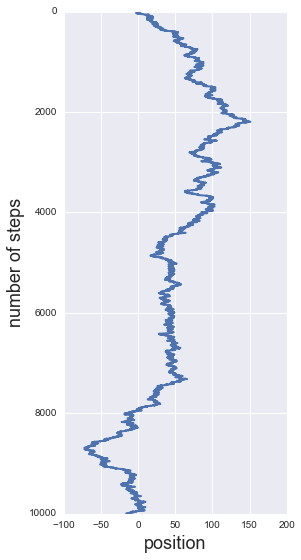

In [10]:
# Number of steps
n_steps = 10000

# Take the walk
walk = unbounded_random_walk(n_steps)

# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.plot(walk, np.arange(n_steps+1))
ax.invert_yaxis()
ax.set_xlabel('position')
ax.set_ylabel('number of steps')

**b)** We can just put our `unbounded_random_walk()` function in a **`for`** loop to compute the walks and their end points.

In [18]:
# Parameters for the walks
n_walks = 100000
n_steps = 1000

# Initialized end points array
end_points = np.empty(n_walks)

# Take the walks and record the end points
for i in range(n_walks):
    end_points[i] = unbounded_random_walk(n_steps)[-1]

Now, we'll plot them.  We'll do both a binned histogram and a cumulative histogram.  Theoretically, the distribution should be close to Gaussian with zero mean and a variance equal to the number of steps.  We will overlay a plot of the Gaussian distribution.

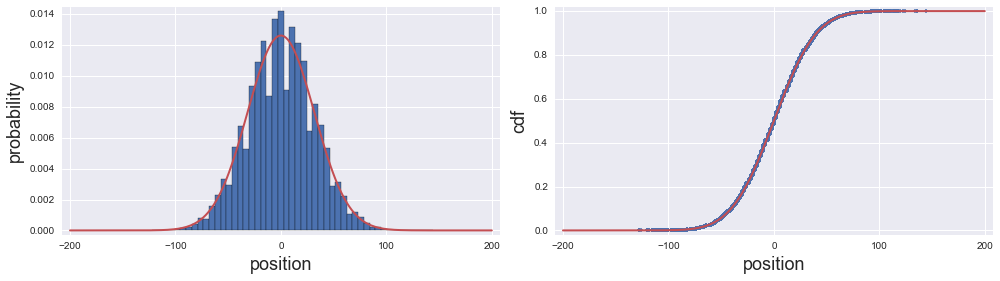

In [29]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

# Plot the histogram
_ = ax[0].hist(end_points, bins=50, normed=True)

# Overlay Gaussian
x_smooth = np.linspace(-200, 200, 200)
var = n_steps
p_smooth = st.norm.pdf(x_smooth, loc=0, scale=np.sqrt(var))
ax[0].plot(x_smooth, p_smooth, linestyle='-', marker='None', 
           color=sns.color_palette()[2])

# Plot the cumulative histogram
ax[1].plot(np.sort(end_points), np.arange(len(end_points)) / len(end_points), 
           marker='.', linestyle='None')

# Overlay Gaussian CDF
ax[1].plot(x_smooth, st.norm.cdf(x_smooth, loc=0, scale=np.sqrt(var)),
           marker='None', linestyle='-', color=sns.color_palette()[2])

# Tidy up plots
for i in [0,1]:
    ax[i].set_xlabel('position')
    ax[i].margins(0.02)
ax[0].set_ylabel('probability')
ax[1].set_ylabel('cdf')
fig.tight_layout()

Notice that the binning in the left plot shows the fact that we have unit steps.  Given that we took an even number of steps, odd displacements are impossible.

**c)** It is a bit trickier to take a bounded random walk.  At each step, we do need to ask if we've hit the wall, so we can just do the simple cumulative sum to get our positions.  This means we need to ask an **`if`** statement at every step.  The code is still pretty straightforward.  At each iteration, we propose a random step.  We check to see if it stepped over a boundary.  If it did, we step the other way.  Otherwise, we accept the step.

For speed purposed, we can compile this with `numba`.  I got about a 50-fold speed boost.

In [87]:
@numba.jit(nopython=True)
def numba_isclose(a, b):
    """numba-able version of np.isclose()"""
    if abs(a - b) < 1e-8:
        return True
    else:
        return False

@numba.jit(nopython=True)
def bounded_random_walk(n_steps, x_min, x_max, x_0=0):
    """Take a bounded random walk."""

    # Initialize positions
    x = np.empty(n_steps + 1)
    x[0] = x_0

    # Take the steps
    for i in range(1, n_steps + 1):
        # If at boundary, either stay or step away
        if x[i-1] - 1 <= x_min:
            step_direction = np.random.randint(0, 2)
        elif x[i-1] + 1 >= x_max:
            step_direction = np.random.randint(-1, 1)
        else:
            step_direction = 2 * np.random.randint(0, 2) - 1

        # Take step
        x[i] = x[i-1] + step_direction
            
    return x

Now, we take and plot the walk as for the unbounded case.

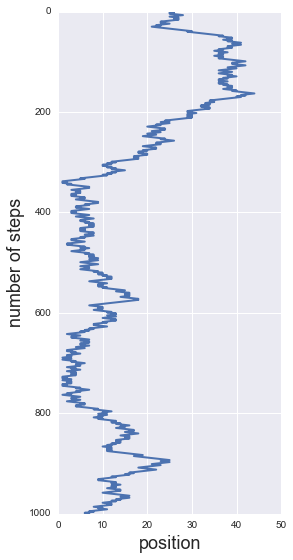

In [90]:
# Parameters
n_steps = 1000
x_min = 0
x_max = 50
x_0 = 25

# Take the walk
walk = bounded_random_walk(n_steps, x_min, x_max, x_0=x_0)

# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.plot(walk, np.arange(n_steps+1))
ax.set_xlim((x_min, x_max))
ax.invert_yaxis()
ax.set_xlabel('position')
ax.set_ylabel('number of steps')

For this particlar walk, we hit the minimum wall a few times and had to step back.

**d)** We proceed as for part (b).  We do not expect the result to be Gaussian, so we do not plot Gaussians.

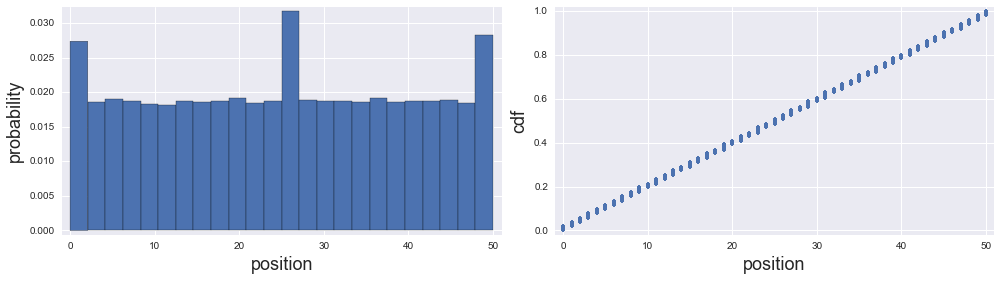

In [79]:
# Parameters for the walks
n_walks = 100000

# Initialized end points array
end_points = np.empty(n_walks)

# Take the walks and record the end points
for i in range(n_walks):
    end_points[i] = bounded_random_walk(n_steps, x_min, x_max, x_0=x_0)[-1]

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

# Plot the histogram
_ = ax[0].hist(end_points, bins=24, normed=True)


# Plot the cumulative histogram
ax[1].plot(np.sort(end_points), np.arange(len(end_points)) / len(end_points), 
           marker='.', linestyle='None')

# Tidy up plots
for i in [0,1]:
    ax[i].set_xlabel('position')
    ax[i].margins(0.02)
ax[0].set_ylabel('probability')
ax[1].set_ylabel('cdf')
fig.tight_layout()

Again, we see binning effects in the histogram because of unit step size.  However, it is clear that the distribution is uniform.

**e)** If we were being Pythonic, we could accect a function decsribing the diffusion coefficient as an argument into our bounded random walk with varying diffusion coefficient.  However, we do care about speed here, so I'm going to hard-code a linear dependence.

In [91]:
@numba.jit(nopython=True)
def bounded_random_walk_varing_diffusion(n_steps, x_min, x_max, m, b, x_0=0):
    """Take a bounded random walk."""
    
    # Check to make sure we can't get negative D
    if (m * x_max + b) < 0 or (m * x_min + b) < 0:
        raise RuntimeError('Invalid parameters.')

    # Initialize positions
    x = np.empty(n_steps + 1)
    x[0] = x_0

    # Take the steps
    for i in range(1, n_steps + 1):
        # Determine step length (linear diffusion coefficient)
        delta = np.sqrt(m * x[i-1] + b)
        
        # If at boundary, either stay or step away
        if x[i-1] - delta <= x_min:
            step_direction = np.random.randint(0, 2)
        elif x[i-1] + delta >= x_max:
            step_direction = np.random.randint(-1, 1)
        else:
            step_direction = 2 * np.random.randint(0, 2) - 1

        # Take step
        x[i] = x[i-1] + delta * step_direction
        
    return x

We can now take our walk!

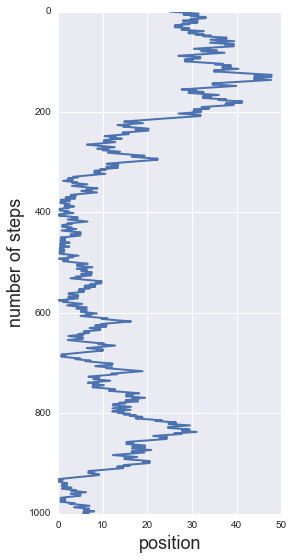

In [92]:
# Parameters
n_steps = 1000
x_min = 0
x_max = 50
x_0 = 25
m = 3 / 50
b = 1

# Take the walk
walk = bounded_random_walk_varing_diffusion(n_steps, x_min, x_max, m, b, x_0=x_0)

# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.plot(walk, np.arange(n_steps+1))
ax.set_xlim((x_min, x_max))
ax.invert_yaxis()
ax.set_xlabel('position')
ax.set_ylabel('number of steps')

**f)** Finally, we will do statistics on watching all the "molecules" in the cell do their walks and see if we have a concentration gradient.  This will tell us if the retarded diffusion model is reasonable.  We proceed as in (d).

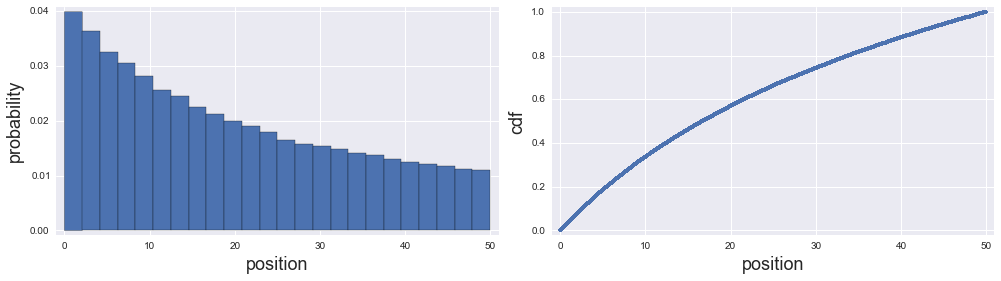

In [94]:
# Parameters for the walks
n_walks = 100000

# Initialized end points array
end_points = np.empty(n_walks)

# Take the walks and record the end points
for i in range(n_walks):
    # Random starting point
    x_0 = np.random.random() * (x_max - x_min) + x_min
    end_points[i] = bounded_random_walk_varing_diffusion(
                                        n_steps, x_min, x_max, m, b, x_0=x_0)[-1]

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

# Plot the histogram
_ = ax[0].hist(end_points, bins=24, normed=True)


# Plot the cumulative histogram
ax[1].plot(np.sort(end_points), np.arange(len(end_points)) / len(end_points), 
           marker='.', linestyle='None')

# Tidy up plots
for i in [0,1]:
    ax[i].set_xlabel('position')
    ax[i].margins(0.02)
ax[0].set_ylabel('probability')
ax[1].set_ylabel('cdf')
fig.tight_layout()

Indeed, we see a concentration gradient!  It is not that dissimilar from what Griffin, et al. measured. The retarded diffusion hypothesis is at least plausible.